# **Waste Material Segregation for Improving Waste Management**

## **Objective**

The objective of this project is to implement an effective waste material segregation system using convolutional neural networks (CNNs) that categorises waste into distinct groups. This process enhances recycling efficiency, minimises environmental pollution, and promotes sustainable waste management practices.

The key goals are:

* Accurately classify waste materials into categories like cardboard, glass, paper, and plastic.
* Improve waste segregation efficiency to support recycling and reduce landfill waste.
* Understand the properties of different waste materials to optimise sorting methods for sustainability.

## **Data Understanding**

The Dataset consists of images of some common waste materials.

1. Food Waste
2. Metal
3. Paper
4. Plastic
5. Other
6. Cardboard
7. Glass


**Data Description**

* The dataset consists of multiple folders, each representing a specific class, such as `Cardboard`, `Food_Waste`, and `Metal`.
* Within each folder, there are images of objects that belong to that category.
* However, these items are not further subcategorised. <br> For instance, the `Food_Waste` folder may contain images of items like coffee grounds, teabags, and fruit peels, without explicitly stating that they are actually coffee grounds or teabags.

## **1. Load the data**

Load and unzip the dataset zip file.

**Import Necessary Libraries**

In [ ]:
# Recommended versions:

# numpy version: 1.26.4
# pandas version: 2.2.2
# seaborn version: 0.13.2
# matplotlib version: 3.10.0
# PIL version: 11.1.0
# tensorflow version: 2.18.0
# keras version: 3.8.0
# sklearn version: 1.6.1

In [3]:
# Import essential libraries
import pandas as pd
import numpy as np
import zipfile
import os
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras import layers, models, regularizers
from keras import callbacks
from keras import applications
from keras import utils
from sklearn.metrics import classification_report, confusion_matrix

%matplotlib inline

# **First step - Upload data.zip file to google drive, before executing the below code.**

In [1]:
#internal used for colab
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


Load the dataset.

In [4]:
# Load and unzip the dataset
#internal used for colab
zip_file_path = '/content/drive/My Drive/Colab Notebooks/data.zip'

# Define the directory where you want to extract the contents
# use for Colab
extraction_path = 'extracted_data'

# Use for Kaggle
# extraction_path = '/kaggle/input/waste-segregation/'

# Create the extraction directory if it doesn't exist
os.makedirs(extraction_path, exist_ok=True)

# Unzip the file
try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extraction_path)
    print(f"Successfully unzipped '{zip_file_path}' to '{extraction_path}/'")
except FileNotFoundError:
    print(f"Error: The file '{zip_file_path}' was not found. Please check the path and ensure the file is uploaded.")
except zipfile.BadZipFile:
    print(f"Error: '{zip_file_path}' is not a valid zip file or is corrupted.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")


Successfully unzipped '/content/drive/My Drive/Colab Notebooks/data.zip' to 'extracted_data/'


## **2. Data Preparation** <font color=red> [25 marks] </font><br>


### **2.1 Load and Preprocess Images** <font color=red> [8 marks] </font><br>

Let us create a function to load the images first. We can then directly use this function while loading images of the different categories to load and crop them in a single step.

#### **2.1.1** <font color=red> [3 marks] </font><br>
Create a function to load the images.

In [ ]:
# Create a function to load the raw images

def load_raw_image(file_path):
    """
    Loads an image from the specified file path.

    Args:
        file_path (str): The path to the image file.

    Returns:
        PIL.Image.Image: The loaded image object. Returns None if the file
                         does not exist or is not a valid image.
    """
    if not os.path.exists(file_path):
        print(f"Error: File not found at '{file_path}'")
        return None

    try:
        # Open the image file
        image = Image.open(file_path)
        print(f"Successfully loaded image from '{file_path}' (Format: {image.format}, Mode: {image.mode}, Size: {image.size})")
        return image
    except FileNotFoundError:
        print(f"Error: File not found at '{file_path}' during image opening.")
        return None
    except IOError:
        print(f"Error: Could not open or identify image file '{file_path}'. It might be corrupted or not a valid image format.")
        return None
    except Exception as e:
        print(f"An unexpected error occurred while loading image '{file_path}': {e}")
        return None

#### **2.1.2** <font color=red> [5 marks] </font><br>
Load images and labels.

Load the images from the dataset directory. Labels of images are present in the subdirectories.

Verify if the images and labels are loaded correctly.

In [ ]:
# Get the images and their labels

def load_images_with_labels(dataset_dir):

    if not os.path.isdir(dataset_dir):
        print(f"Error: Dataset directory not found at '{dataset_dir}'")
        return []

    loaded_data = []
    supported_image_extensions = ('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff')
    label_counts = {}
    total_images_loaded = 0

    print(f"Scanning directory: {dataset_dir}")

    # Walk through the dataset directory
    for root, dirs, files in os.walk(dataset_dir):
        # The subdirectory name is the label
        relative_path = os.path.relpath(root, dataset_dir)
        if relative_path == '.': # This is the root dataset_dir itself
            continue

        label = os.path.basename(root) # The last part of the path is the label

        # Initialize label count if not already present
        if label not in label_counts:
            label_counts[label] = 0

        for file_name in files:
            # Check if the file is an image
            if file_name.lower().endswith(supported_image_extensions):
                file_path = os.path.join(root, file_name)
                image = load_raw_image(file_path) # Use the helper function to load the image

                if image:
                    loaded_data.append((image, label))
                    label_counts[label] += 1
                    total_images_loaded += 1
                else:
                    print(f"Skipping '{file_path}' due to loading error.")

    # summary of loaded images and labels
    print("\n--- Raw Image and Label Loading Verification ---")
    print(f"Total raw images loaded: {total_images_loaded}")
    print("Raw images loaded per label:")
    if label_counts:
        for label, count in label_counts.items():
            print(f"  - {label}: {count} images")
    else:
        print("  No labels or raw images found.")

    return loaded_data


In [ ]:
data_path = extraction_path + "/data"
raw_loaded_dataset = load_images_with_labels(data_path)

Scanning directory: /kaggle/input/waste-segregation//data
Successfully loaded image from '/kaggle/input/waste-segregation//data/Metal/file_779.png' (Format: PNG, Mode: RGB, Size: (256, 256))
Successfully loaded image from '/kaggle/input/waste-segregation//data/Metal/file_28.png' (Format: PNG, Mode: RGB, Size: (256, 256))
Successfully loaded image from '/kaggle/input/waste-segregation//data/Metal/file_326.png' (Format: PNG, Mode: RGB, Size: (256, 256))
Successfully loaded image from '/kaggle/input/waste-segregation//data/Metal/file_900.png' (Format: PNG, Mode: RGB, Size: (256, 256))
Successfully loaded image from '/kaggle/input/waste-segregation//data/Metal/file_170.png' (Format: PNG, Mode: RGB, Size: (256, 256))
Successfully loaded image from '/kaggle/input/waste-segregation//data/Metal/file_814.png' (Format: PNG, Mode: RGB, Size: (256, 256))
Successfully loaded image from '/kaggle/input/waste-segregation//data/Metal/file_877.png' (Format: PNG, Mode: RGB, Size: (256, 256))
Successfully

Perform any operations, if needed, on the images and labels to get them into the desired format.

In [ ]:
def process_image_dataset(raw_dataset, target_size=(128, 128), img_mode='RGB', normalize_pixels=True):

    processed_images = []
    string_labels = []

    print(f"\n--- Processing Raw Dataset ---")
    print(f"Target image size: {target_size}")
    print(f"Target image mode: {img_mode}")
    print(f"Pixel normalization: {normalize_pixels}")

    for img, label in raw_dataset:
        try:
            # 1. Convert image mode
            img = img.convert(img_mode)

            # 2. Crop image
            width, height = img.size
            min_dim = min(width, height)
            left = (width - min_dim) // 2
            top = (height - min_dim) // 2
            right = left + min_dim
            bottom = top + min_dim
            img = img.crop((left, top, right, bottom))

            # 3. Resize image
            img = img.resize(target_size, Image.Resampling.LANCZOS) # LANCZOS is a high-quality downsampling filter

            # 4. Convert PIL Image to NumPy array
            img_array = np.array(img)

            # 5. Normalize pixel values
            if normalize_pixels:
                img_array = img_array.astype(np.float32) / 255.0

            processed_images.append(img_array)
            string_labels.append(label)
        except Exception as e:
            print(f"Error processing image with label '{label}': {e}. Skipping this image.")
            continue

    # Convert lists to NumPy arrays
    processed_images_np = np.array(processed_images)

    # 5. Encode labels (string to integer)
    unique_labels = sorted(list(set(string_labels)))
    label_to_int = {label: i for i, label in enumerate(unique_labels)}
    int_to_label = {i: label for label, i in label_to_int.items()}

    processed_labels_np = np.array([label_to_int[label] for label in string_labels])

    return processed_images_np, processed_labels_np, label_to_int, int_to_label

In [ ]:
processed_images_np, processed_labels_np, label_to_int_map, int_to_label_map = \
process_image_dataset(raw_loaded_dataset, target_size=(128, 128), img_mode='RGB', normalize_pixels=True)

# Verification after processing
print("\n--- Processed Dataset Verification ---")
print(f"\nFinal processed images shape: {processed_images_np.shape}")
print(f"Final processed labels shape: {processed_labels_np.shape}")
print(f"Number of unique classes: {len(label_to_int_map.keys())}")
print(f"Label to int mapping: {label_to_int_map}")
print(f"Int to label mapping: {int_to_label_map}")


--- Processing Raw Dataset ---
Target image size: (128, 128)
Target image mode: RGB
Pixel normalization: True

--- Processed Dataset Verification ---

Final processed images shape: (7625, 128, 128, 3)
Final processed labels shape: (7625,)
Number of unique classes: 7
Label to int mapping: {'Cardboard': 0, 'Food_Waste': 1, 'Glass': 2, 'Metal': 3, 'Other': 4, 'Paper': 5, 'Plastic': 6}
Int to label mapping: {0: 'Cardboard', 1: 'Food_Waste', 2: 'Glass', 3: 'Metal', 4: 'Other', 5: 'Paper', 6: 'Plastic'}


### **2.2 Data Visualisation** <font color=red> [9 marks] </font><br>

#### **2.2.1** <font color=red> [3 marks] </font><br>
Create a bar plot to display the class distribution

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


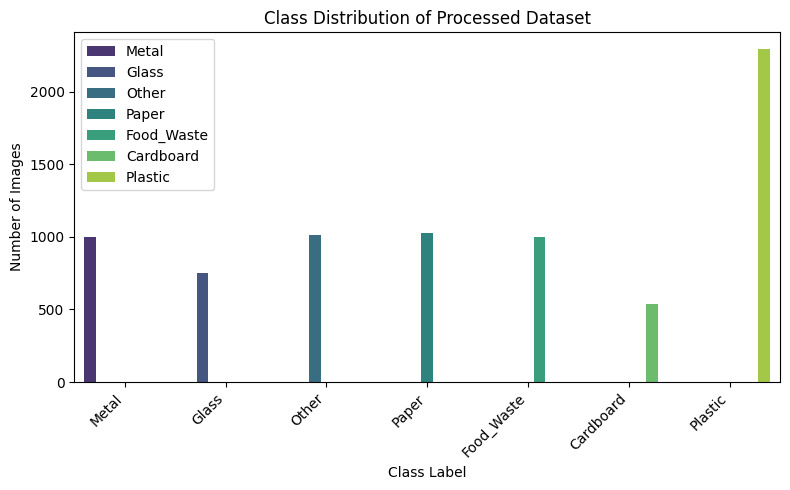

In [ ]:
# Visualise Data Distribution

# Count occurrences of each label
label_counts = Counter(processed_labels_np)

# Prepare data for plotting
labels_int = list(label_counts.keys())
counts = list(label_counts.values())

# Map integer labels back to original string labels for readability
string_labels_for_plot = [int_to_label_map[int_id] for int_id in labels_int]

plt.figure(figsize=(8, 5))
sns.barplot(x=string_labels_for_plot, y=counts, hue=string_labels_for_plot,  palette='viridis')
plt.xlabel('Class Label')
plt.ylabel('Number of Images')
plt.title('Class Distribution of Processed Dataset')
plt.xticks(rotation=45, ha='right') # Rotate labels if they overlap
plt.tight_layout() # Adjust layout to prevent labels from cutting off
plt.show()


#### **2.2.2** <font color=red> [3 marks] </font><br>
Visualise some sample images

In [ ]:
# Visualise Sample Images (across different labels)

def visualize_sample_images(images, labels, int_to_label_map):

    print(f"\n--- Visualizing Sample Images per class ---")

    unique_labels_int = np.unique(labels)
    num_classes = len(unique_labels_int)

    if num_classes == 0 or images.shape[0] == 0:
        print("No images or labels available to visualize.")
        return

    plt.figure(figsize=(10, 10)) # Adjust figure size based on samples and classes

    for i, label_int in enumerate(unique_labels_int):
        # Get indices of images belonging to the current label
        class_indices = np.where(labels == label_int)[0]

        # Get the string label
        label_str = int_to_label_map[label_int]

        # Select a few random samples (or all if less than num_samples_per_class)
        # Ensure we don't try to sample more than available images
        sample_indices = np.random.choice(
            class_indices,
            replace=False
        )

        # for j, img_idx in enumerate(sample_indices):
        plt.subplot(1, len(unique_labels_int), i + 1)

        display_image = images[sample_indices]

        plt.imshow(display_image)
        plt.title(f"{label_str}")
        plt.axis('off')


    plt.tight_layout()
    plt.show()

In [ ]:
visualize_sample_images(processed_images_np, processed_labels_np, int_to_label_map)


--- Visualizing Sample Images per class ---


#### **2.2.3** <font color=red> [3 marks] </font><br>
Based on the smallest and largest image dimensions, resize the images.

In [ ]:
# Find the smallest and largest image dimensions from the data set

def analyze_image_dimensions(raw_dataset):

    if not raw_dataset:
        print("No raw images available to analyze dimensions.")
        return

    min_width, min_height = float('inf'), float('inf')
    max_width, max_height = 0, 0

    for img, _ in raw_dataset:
        width, height = img.size
        min_width = min(min_width, width)
        min_height = min(min_height, height)
        max_width = max(max_width, width)
        max_height = max(max_height, height)

    print(f"Smallest Image Dimensions: Width={min_width}, Height={min_height}")
    print(f"Largest Image Dimensions: Width={max_width}, Height={max_height}")

print("\n--- Analyzing Raw Image Dimensions ---")
analyze_image_dimensions(raw_loaded_dataset)


--- Analyzing Raw Image Dimensions ---
Smallest Image Dimensions: Width=256, Height=256
Largest Image Dimensions: Width=256, Height=256


In [ ]:
# Resize the image dimensions
print(f"Dimensions after Image resizing: Width={processed_images_np.shape[1]}, Height={processed_images_np.shape[2]}")

Dimensions after Image resizing: Width=128, Height=128


### **2.3 Encoding the classes** <font color=red> [3 marks] </font><br>

There are seven classes present in the data.

We have extracted the images and their labels, and visualised their distribution. Now, we need to perform encoding on the labels. Encode the labels suitably.

####**2.3.1** <font color=red> [3 marks] </font><br>
Encode the target class labels.

In [ ]:
# Encode the labels suitably

print(f"Final processed labels (integer-encoded) shape: {processed_labels_np.shape}")
print(f"Final processed labels : {pd.DataFrame(processed_labels_np).value_counts()}")
print(f"Label to int mapping: {label_to_int_map}")

# one-hot encoded approach
print(f"\n------One Hot Encoding------")
encoded_class = utils.to_categorical(processed_labels_np, num_classes=len(label_to_int_map.keys()))
print("Original label:", processed_labels_np[0])
print("One-hot encoded label:", encoded_class[0])
print("Shape of encoded labels:", encoded_class.shape)

Final processed labels (integer-encoded) shape: (7625,)
Final processed labels : 0
6    2295
5    1030
4    1010
1    1000
3    1000
2     750
0     540
Name: count, dtype: int64
Label to int mapping: {'Cardboard': 0, 'Food_Waste': 1, 'Glass': 2, 'Metal': 3, 'Other': 4, 'Paper': 5, 'Plastic': 6}

------One Hot Encoding------
Original label: 3
One-hot encoded label: [0. 0. 0. 1. 0. 0. 0.]
Shape of encoded labels: (7625, 7)


### **2.4 Data Splitting** <font color=red> [5 marks] </font><br>

#### **2.4.1** <font color=red> [5 marks] </font><br>
Split the dataset into training and validation sets

In [ ]:
# Assign specified parts of the dataset to train and validation sets

x_train, x_val, y_train, y_val = train_test_split(
        processed_images_np, encoded_class, test_size=0.2, random_state=42, stratify=processed_labels_np
    )

print(f"Shape of training images (x_train): {x_train.shape}")
print(f"Shape of validation images (x_val): {x_val.shape}")
print(f"Shape of training labels (y_train): {y_train.shape}")
print(f"Shape of validation labels (y_val): {y_val.shape}")

Shape of training images (x_train): (6100, 128, 128, 3)
Shape of validation images (x_val): (1525, 128, 128, 3)
Shape of training labels (y_train): (6100, 7)
Shape of validation labels (y_val): (1525, 7)


## **3. Model Building and Evaluation** <font color=red> [20 marks] </font><br>

### **3.1 Model building and training** <font color=red> [15 marks] </font><br>

#### **3.1.1** <font color=red> [10 marks] </font><br>
Build and compile the model. Use 3 convolutional layers. Add suitable normalisation, dropout, and fully connected layers to the model.

Test out different configurations and report the results in conclusions.

In [ ]:
# Build and compile the model

def build_and_compile_cnn_model(input_shape, num_classes, learning_rate=0.001,
                                conv_filters=[64, 128, 256], dense_neurons=512,
                                l2_reg=0.0001, dropout_conv=0.25, dropout_dense=0.5,
                                use_dropout=False):
    """
    Builds and compiles a Convolutional Neural Network (CNN) model with customizable parameters.

    Args:
        input_shape (tuple): The shape of the input images (height, width, channels).
        num_classes (int): The number of unique output classes.
        learning_rate (float): The learning rate for the Adam optimizer.
        conv_filters (list): A list of integers specifying the number of filters for each conv layer.
        dense_neurons (int): Number of neurons in the first fully connected dense layer.
        l2_reg (float): L2 regularization factor.
        dropout_conv (float): Dropout rate after convolutional blocks.
        dropout_dense (float): Dropout rate after the fully connected layers.
        use_dropout(boolean): Use of Dropout

    Returns:
        tf.keras.Model: The compiled Keras CNN model.
    """
    print(f"\n--- Building and Compiling CNN Model (Config: Filters={conv_filters}, Dense={dense_neurons}, LR={learning_rate}, L2={l2_reg}, DO_Conv={dropout_conv}, DO_Dense={dropout_dense}) ---")
    print(f"Input Shape: {input_shape}")
    print(f"Number of Classes: {num_classes}")
    print(f"Use Dropout: {use_dropout}")

    model = models.Sequential()

    # First Convolutional Block
    model.add(layers.Conv2D(conv_filters[0], (3, 3), activation='relu', input_shape=input_shape,
                            padding='same', kernel_regularizer=regularizers.l2(l2_reg)))

    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D())
    if use_dropout:
      model.add(layers.Dropout(dropout_conv))

    # Second Convolutional Block
    model.add(layers.Conv2D(conv_filters[1], (3, 3), activation='relu',
                            padding='same', kernel_regularizer=regularizers.l2(l2_reg)))

    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    if use_dropout:
      model.add(layers.Dropout(dropout_conv))

    # Third Convolutional Block
    model.add(layers.Conv2D(conv_filters[2], (3, 3), activation='relu',
                            padding='same', kernel_regularizer=regularizers.l2(l2_reg)))

    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    if use_dropout:
      model.add(layers.Dropout(dropout_conv))

    # Flatten layer
    model.add(layers.Flatten())

    # Fully Connected (Dense) Layers
    model.add(layers.Dense(dense_neurons, activation='relu',
                           kernel_regularizer=regularizers.l2(l2_reg)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(dropout_dense))

    model.add(layers.Dense(dense_neurons // 2, activation='relu',
                           kernel_regularizer=regularizers.l2(l2_reg)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(dropout_dense))

    model.add(layers.Dense(num_classes, activation='softmax')) # Output layer

    # Compile the model
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
# Build and compile the model

# Build and compile the model with Batch Normalization, without dropout configuration
cnn_model = build_and_compile_cnn_model(
        input_shape=x_train.shape[1:],
        num_classes=len(label_to_int_map.keys()),
        learning_rate=0.001,
        conv_filters=[64, 128, 256],
        dense_neurons=512,
        l2_reg=0.0001,
        dropout_conv=0.5,
        dropout_dense=0.7,
        use_dropout=True
    )

# Print a summary of the model architecture
cnn_model.summary()


--- Building and Compiling CNN Model (Config: Filters=[64, 128, 256], Dense=512, LR=0.001, L2=0.0001, DO_Conv=0.5, DO_Dense=0.7) ---
Input Shape: (128, 128, 3)
Number of Classes: 7
Use Dropout: True


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1750350835.733173      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1750350835.733800      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      33,554,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │              

 Total params: 34,063,751 (129.94 MB)

 Trainable params: 34,061,319 (129.93 MB)

 Non-trainable params: 2,432 (9.50 KB)

#### **3.1.2** <font color=red> [5 marks] </font><br>
Train the model.

Use appropriate metrics and callbacks as needed.

In [ ]:
# Training
print("\n--- Training the Model ---")

# Define training parameters
epochs = 20
batch_size = 32 # Common batch size

# Define Callbacks
# Early Stopping: Stop training when validation loss stops improving for 'patience' epochs
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Model Checkpoint: Save the best model weights based on validation accuracy
model_checkpoint = callbacks.ModelCheckpoint(
    'my_model.keras', # File path to save the model
    monitor='val_accuracy',
    save_best_only=True,
    mode='max', # Save when validation accuracy is maximized
    verbose=1
)

# Train the model
history = cnn_model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

print("\n--- Training Complete ---")


--- Training the Model ---
Epoch 1/20


I0000 00:00:1750350846.272436      65 service.cc:148] XLA service 0x7a47700165c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750350846.273395      65 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1750350846.273423      65 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1750350846.884204      65 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/191 ━━━━━━━━━━━━━━━━━━━━ 13s 69ms/step - accuracy: 0.1484 - loss: 4.1085 

I0000 00:00:1750350855.644478      65 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.2000 - loss: 3.3938
Epoch 1: val_accuracy improved from -inf to 0.26885, saving model to my_model.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 38s 121ms/step - accuracy: 0.2001 - loss: 3.3926 - val_accuracy: 0.2689 - val_loss: 4.2850
Epoch 2/20
190/191 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.2712 - loss: 2.6772
Epoch 2: val_accuracy did not improve from 0.26885
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.2712 - loss: 2.6769 - val_accuracy: 0.2374 - val_loss: 3.2459
Epoch 3/20
190/191 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.2871 - loss: 2.5247
Epoch 3: val_accuracy improved from 0.26885 to 0.31738, saving model to my_model.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 63ms/step - accuracy: 0.2871 - loss: 2.5246 - val_accuracy: 0.3174 - val_loss: 2.5258
Epoch 4/20
190/191 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.3365 - loss: 2.4138
Epoch 4: val_accuracy improved from 0.31738 to 0.35869, saving model to my_model.ke

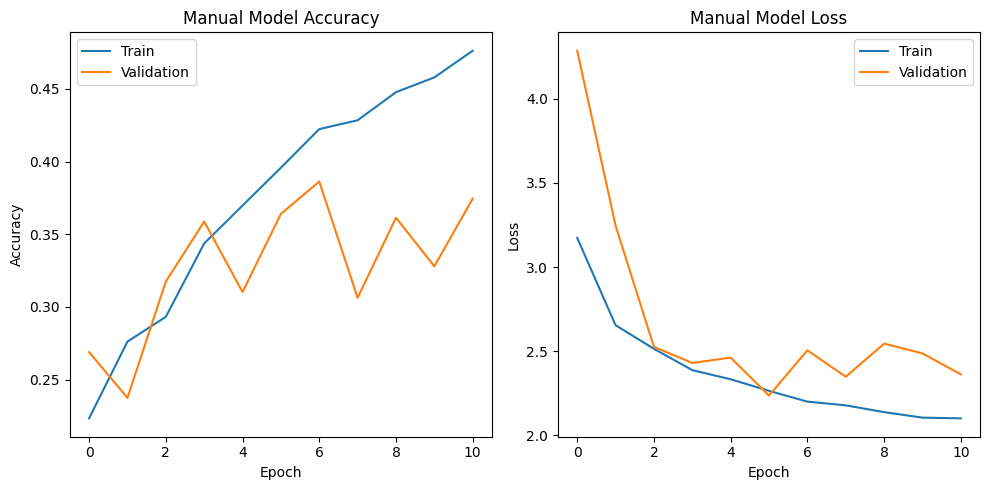

In [ ]:
# Plot training history for Manual Model
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title(f'Manual Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title(f'Manual Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()

### **Analysis**
Based on both the accuracy and loss plots, the CNN model is **clearly overfitting**.

- The training accuracy continues to improve, and training loss continues to decrease, suggesting the model is learning the training data well.
- The validation accuracy plateaus and fluctuates, and the validation loss remains significantly higher and also fluctuates, indicating that the model is not generalizing effectively to new, unseen data.

### **Model Building using pre-defined model and transfer learning.**

**RESNET50 MODEL**

In [ ]:
# Load pre-trained ResNet50 model without the top classification layer
base_model = applications.ResNet50(weights='imagenet', include_top=False, input_tensor=tf.keras.layers.Input(x_train.shape[1:]))

# Freeze the layers of the base model
for layer in base_model.layers[-4:]:
  layer.trainable = False

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = layers.Dropout(0.7)(x)
output_layer = layers.Dense(len(label_to_int_map.keys()), activation='softmax')(x)

model_resnet = keras.Model(inputs=base_model.input, outputs=output_layer)


# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
model_resnet.compile(optimizer=optimizer,
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# Print a summary of the model architecture
model_resnet.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 134, 134, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 64, 64, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 64, 64, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 64, 64, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 66, 66, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 32, 32, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 32, 32, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 32, 32, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 32, 32, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 32, 32, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 24,114,055 (91.99 MB)

 Trainable params: 23,006,215 (87.76 MB)

 Non-trainable params: 1,107,840 (4.23 MB)

In [ ]:
# Training RESNET50 Model
print("\n--- Training the RESNET50 Model ---")

# Define training parameters
resnet_epochs = 30
resnet_batch_size = 32 # Common batch size

# Define Callbacks
# Early Stopping: Stop training when validation loss stops improving for 'patience' epochs
resnet_early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Model Checkpoint: Save the best model weights based on validation accuracy
resnet_model_checkpoint = callbacks.ModelCheckpoint(
    'resnet50_best.keras', # File path to save the model
    monitor='val_accuracy',
    save_best_only=True,
    mode='max', # Save when validation accuracy is maximized
    verbose=1
)


# Train the RESNET50 model
history_resnet = model_resnet.fit(
    x_train, y_train,
    epochs=resnet_epochs,
    batch_size=resnet_batch_size,
    validation_data=(x_val, y_val),
    callbacks=[resnet_early_stopping, resnet_model_checkpoint],
    verbose=1
)

print("\n--- Training RESNET50 Model Complete ---")


--- Training the RESNET50 Model ---
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_211']
Received: inputs=Tensor(shape=(None, 128, 128, 3))
  warnings.warn(msg)


191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.1971 - loss: 3.1843
Epoch 1: val_accuracy improved from -inf to 0.29115, saving model to resnet50_best.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 122s 284ms/step - accuracy: 0.1973 - loss: 3.1829 - val_accuracy: 0.2911 - val_loss: 3.3412
Epoch 2/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.3558 - loss: 2.2638
Epoch 2: val_accuracy improved from 0.29115 to 0.29770, saving model to resnet50_best.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 25s 131ms/step - accuracy: 0.3559 - loss: 2.2634 - val_accuracy: 0.2977 - val_loss: 4.7456
Epoch 3/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.4736 - loss: 1.9092
Epoch 3: val_accuracy improved from 0.29770 to 0.31541, saving model to resnet50_best.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 25s 132ms/step - accuracy: 0.4737 - loss: 1.9090 - val_accuracy: 0.3154 - val_loss: 2.9573
Epoch 4/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.5585 - loss: 1.6540
Epoch 4: val_accuracy imp

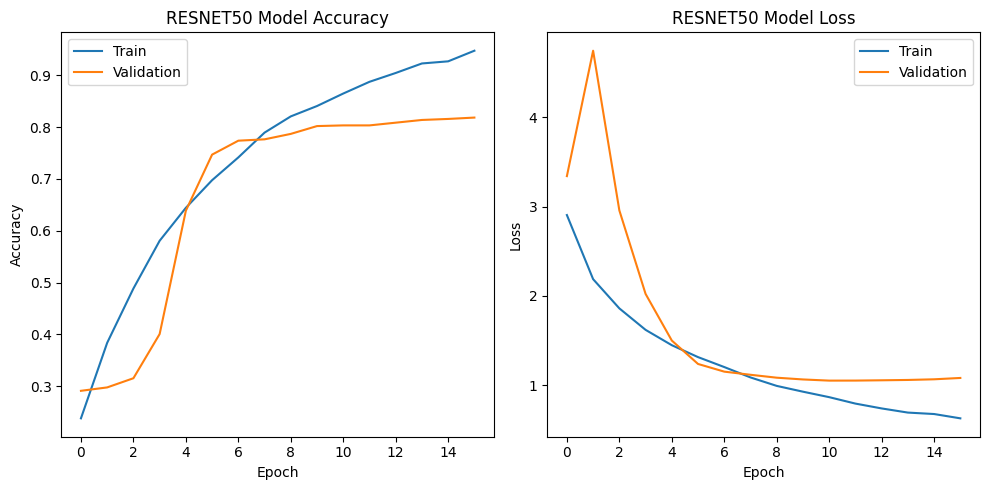

In [ ]:
# Plot training history for RESNET50 Model
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history_resnet.history['accuracy'], label='Train')
plt.plot(history_resnet.history['val_accuracy'], label='Validation')
plt.title(f'RESNET50 Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history_resnet.history['loss'], label='Train')
plt.plot(history_resnet.history['val_loss'], label='Validation')
plt.title(f'RESNET50 Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()

**RESNET50 Model Analysis**

- The RESNET50 model exhibits strong learning capabilities on the training data, achieving high accuracy and low loss.
- However, the performance on the validation set is also good.validation accuracy and loss are almost inline with training data.

### **3.2 Model Testing and Evaluation** <font color=red> [5 marks] </font><br>

#### **3.2.1** <font color=red> [5 marks] </font><br>
Evaluate the model on test dataset. Derive appropriate metrics.

#### **Evaluate Manual CNN model**

In [ ]:
# Evaluate on the test set; display suitable metrics

print("\n--- Evaluating Model on Validation Set ---")
val_loss, val_accuracy = cnn_model.evaluate(x_val, y_val, verbose=1)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")


--- Evaluating Model on Validation Set ---
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3640 - loss: 2.2360
Validation Loss: 2.2366
Validation Accuracy: 0.3639


In [ ]:
y_pred_probs = cnn_model.predict(x_val)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_val, axis=1)
print(classification_report(y_true_classes, y_pred_classes, target_names=label_to_int_map.keys()))

48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step
              precision    recall  f1-score   support

   Cardboard       0.51      0.64      0.57       108
  Food_Waste       0.66      0.30      0.42       200
       Glass       0.27      0.39      0.32       150
       Metal       0.21      0.69      0.33       200
       Other       0.16      0.01      0.03       202
       Paper       0.40      0.17      0.24       206
     Plastic       0.59      0.42      0.49       459

    accuracy                           0.36      1525
   macro avg       0.40      0.37      0.34      1525
weighted avg       0.43      0.36      0.35      1525



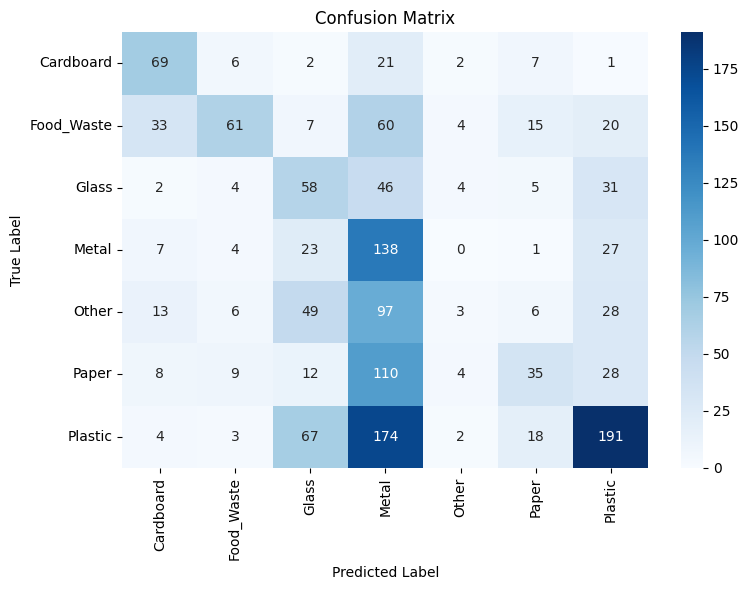

In [ ]:
# Compute confusion matrix for Manual CNN model
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot it
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_to_int_map.keys(), yticklabels=label_to_int_map.keys())

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [ ]:
# Evaluate on the test set; display suitable metrics

print("\n--- Evaluating RESNET Model on Validation Set ---")
resnet_val_loss, resnet_val_accuracy = model_resnet.evaluate(x_val, y_val, verbose=1)
print(f"Validation Loss: {resnet_val_loss:.4f}")
print(f"Validation Accuracy: {resnet_val_accuracy:.4f}")


--- Evaluating RESNET Model on Validation Set ---
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8149 - loss: 1.0072
Validation Loss: 1.0510
Validation Accuracy: 0.8033


In [ ]:
y_pred_probs_resnet = model_resnet.predict(x_val)
y_pred_classes_resnet = np.argmax(y_pred_probs_resnet, axis=1)
y_true_classes_resnet = np.argmax(y_val, axis=1)
print(classification_report(y_true_classes_resnet, y_pred_classes_resnet, target_names=label_to_int_map.keys()))

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_211']
Received: inputs=Tensor(shape=(32, 128, 128, 3))
  warnings.warn(msg)


47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_211']
Received: inputs=Tensor(shape=(None, 128, 128, 3))
  warnings.warn(msg)


48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 114ms/step
              precision    recall  f1-score   support

   Cardboard       0.92      0.81      0.86       108
  Food_Waste       0.81      0.83      0.82       200
       Glass       0.83      0.74      0.78       150
       Metal       0.87      0.84      0.86       200
       Other       0.81      0.70      0.75       202
       Paper       0.68      0.76      0.71       206
     Plastic       0.80      0.86      0.83       459

    accuracy                           0.80      1525
   macro avg       0.82      0.79      0.80      1525
weighted avg       0.81      0.80      0.80      1525



In [ ]:
# Compute confusion matrix for RESNET50 Model
cm = confusion_matrix(y_true_classes_resnet, y_pred_classes_resnet)

# Plot it
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_to_int_map.keys(), yticklabels=label_to_int_map.keys())

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

## **4. Data Augmentation** <font color=red> [optional] </font><br>

#### **4.1 Create a Data Augmentation Pipeline**

##### **4.1.1**
Define augmentation steps for the datasets.

In [ ]:
# Define augmentation steps to augment images

print("\n--- Data Augmentation Steps ---")
print("Data augmentation steps for image data.")
print("If 'X_train_resampled' contained actual image arrays, you would apply transformations")
print("like flipping, rotation, scaling, brightness changes, etc., using a library such as 'imgaug'.")
print("These steps help increase the diversity of your training data and prevent overfitting.")
print("Augmentation should ONLY be applied to the training dataset.")



--- Data Augmentation Steps ---
Data augmentation steps for image data.
If 'X_train_resampled' contained actual image arrays, you would apply transformations
like flipping, rotation, scaling, brightness changes, etc., using a library such as 'imgaug'.
These steps help increase the diversity of your training data and prevent overfitting.
Augmentation should ONLY be applied to the training dataset.


Augment and resample the images.
In case of class imbalance, you can also perform adequate undersampling on the majority class and augment those images to ensure consistency in the input datasets for both classes.

Augment the images.

In [ ]:
# Create a function to augment the images

def create_augmentor():
    return keras.preprocessing.image.ImageDataGenerator(
        rotation_range=25,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

In [ ]:
# Create the augmented training dataset

augmentor = create_augmentor()

train_generator = augmentor.flow(x_train, y_train, batch_size=32)

In [ ]:
X_aug_sample, y_aug_sample = next(train_generator)
print("Augmented batch shape:", X_aug_sample.shape)

Augmented batch shape: (32, 128, 128, 3)


##### **4.1.2**

Train the model on the new augmented dataset.

In [ ]:
# Train the model using augmented images

print("\n--- Training the Augmented dataset ---")

# Define training parameters
aug_epochs = 30
aug_batch_size = 32 # Common batch size

# Define Callbacks
# Early Stopping: Stop training when validation loss stops improving for 'patience' epochs
aug_early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Model Checkpoint: Save the best model weights based on validation accuracy
aug_model_checkpoint = callbacks.ModelCheckpoint(
    'augmented_best.keras', # File path to save the model
    monitor='val_accuracy',
    save_best_only=True,
    mode='max', # Save when validation accuracy is maximized
    verbose=1
)


# Train the model
history_aug = model_resnet.fit(
    train_generator,
    validation_data=(x_val, y_val),
    steps_per_epoch=len(x_train) // 32,
    epochs=30,
    callbacks=[aug_early_stopping, aug_model_checkpoint],
    verbose=1
)

print("\n--- Training Augmented dataset is Complete ---")


--- Training the Augmented dataset ---


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_211']
Received: inputs=Tensor(shape=(None, 128, 128, 3))
  warnings.warn(msg)


190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.7012 - loss: 1.3741
Epoch 1: val_accuracy improved from -inf to 0.80984, saving model to augmented_best.keras
190/190 ━━━━━━━━━━━━━━━━━━━━ 80s 225ms/step - accuracy: 0.7013 - loss: 1.3739 - val_accuracy: 0.8098 - val_loss: 1.0672
Epoch 2/30
  1/190 ━━━━━━━━━━━━━━━━━━━━ 29s 157ms/step - accuracy: 0.6875 - loss: 1.3839

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.80984
190/190 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6875 - loss: 1.3839 - val_accuracy: 0.8098 - val_loss: 1.0666
Epoch 3/30
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.7393 - loss: 1.2097
Epoch 3: val_accuracy did not improve from 0.80984
190/190 ━━━━━━━━━━━━━━━━━━━━ 24s 128ms/step - accuracy: 0.7393 - loss: 1.2097 - val_accuracy: 0.8020 - val_loss: 1.0757
Epoch 4/30
  1/190 ━━━━━━━━━━━━━━━━━━━━ 20s 110ms/step - accuracy: 0.6875 - loss: 1.0903
Epoch 4: val_accuracy did not improve from 0.80984
190/190 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6875 - loss: 1.0903 - val_accuracy: 0.8013 - val_loss: 1.0759
Epoch 5/30
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.7688 - loss: 1.1313
Epoch 5: val_accuracy improved from 0.80984 to 0.81246, saving model to augmented_best.keras
190/190 ━━━━━━━━━━━━━━━━━━━━ 27s 139ms/step - accuracy: 0.7688 - loss: 1.1314 - val_accuracy: 0.8125 - val_loss: 1.0554
Epoch 6/30
  1

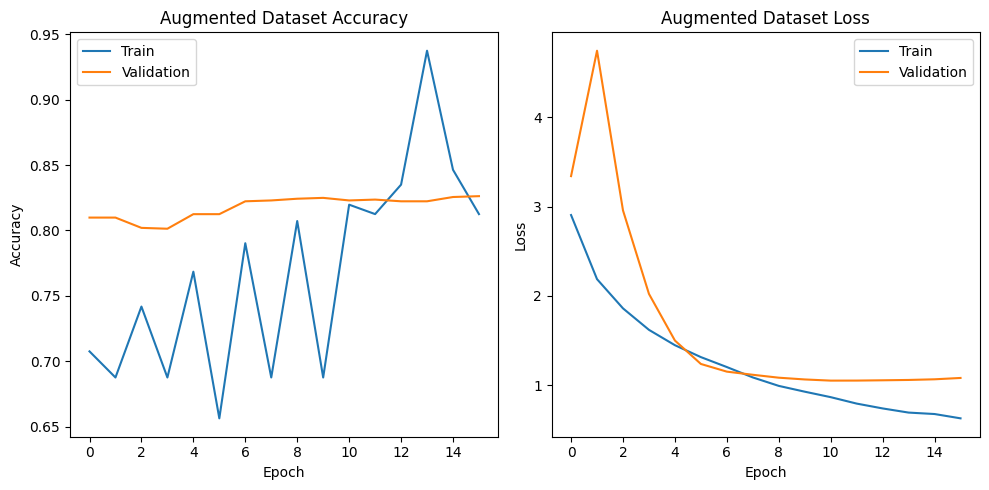

In [ ]:
# Plot training history for Augmented Dataset
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history_aug.history['accuracy'], label='Train')
plt.plot(history_aug.history['val_accuracy'], label='Validation')
plt.title(f'Augmented Dataset Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history_resnet.history['loss'], label='Train')
plt.plot(history_resnet.history['val_loss'], label='Validation')
plt.title(f'Augmented Dataset Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()

## **5. Conclusions** <font color = red> [5 marks]</font>

#### **5.1 Conclude with outcomes and insights gained** <font color =red> [5 marks] </font>

* Report your findings about the data
* Report model training results

**Findings about Data**
- All the images were the size of 256×256. Resize of images is done without loosing the data, inorder to reduce the compute memory issue .
- All the images have 3 channels as RGB.
- The data has seven categories. Cardboard, Food Waste, Glass, Metal, Other, Paper, Plastic
- Class distribution was imbalanced. There was a greater number of images in the plastic category.
- Since there was no equal number of images present in each category, the test and train split was done with stratify=y with an 80/20 ratio.

**Model Training Results**
- Started building own CNN model with 3 convolutional layers, but the accuracy was just 0.40, which was very low. I tried configuring hyperparameters like dropouts, and the performance increased to 0.50.
- As own CNN model is overfitting, used RESNET 50 with transfer learning approach.Initially made all the layers trainable as false observed only 0.60 training accuracy, a slight increase from own CNN model.
- Modified the trainable layers to 20 and got the training accuracy as 98 percent and the validation accuracy as 60%. Clearly the model was overfitting.
- To resolve overfitting problem, modified the trainable layers from 20 to 10, and still able to see the model is overfitting.
- Modified model training layer to 5 and increased the dropout from 0.6 to 0.7 and reduced the learning rate. with these configuration training accuracy: 0.86 and val_accuracy: 0.80 are improved signficantly. Clearly, the model is able to generalize the training data and produce the desired output.
- From the confusion matrix we are able to see a lot of misclassification is done as a plastic when compared to others, which is very little.
- Overall, the model was able to generalize the data and produce the acceptable prediction; nearly 86% of the data is properly classified.

**Summary**
- The model has performed well on the waste segregation task, achieving overall 84% accuracy with strong generalization.